# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Caveats:

- The confirmed cases reported by each country are different from the number of infected people in each country.


- **The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infected people.** For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.


- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.


- The growth rate (or recent doubling time) changes with time, and will eventually fall to zero. So be cautious about extrapolating trends into the future based on current growth rates. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/15/20


,3/15/20
Country/Region,
China,81003
Italy,24747
Iran,13938
"Korea, South",8162
Spain,7798
Germany,5795
France,4513
US,3499
Switzerland,2200


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 81003
	Confirmed cases on 3/8/20 	 80823
	Ratio: 1.0
	Weekly increase: 0.2 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 2181.1 days

** Based on Logistic Fit**

	R^2: 0.995047544151
	Doubling Time (during middle of growth):  6.46 (± 0.58 ) days


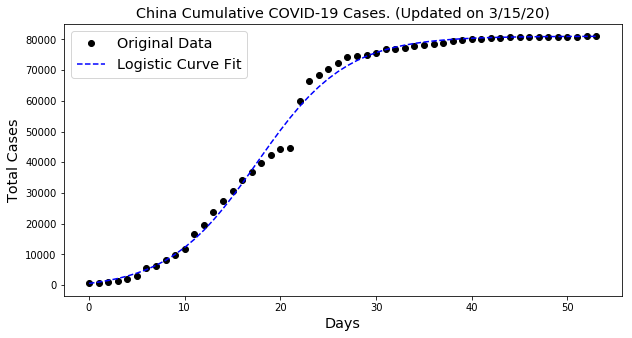



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 24747
	Confirmed cases on 3/8/20 	 7375
	Ratio: 3.36
	Weekly increase: 235.6 %
	Daily increase: 18.9 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.995964094192
	Doubling Time (during middle of growth):  7.09 (± 0.89 ) days

** Based on Exponential Fit **

	R^2: 0.995735453061
	Doubling Time (represents overall growth):  3.76 (± 0.16 ) days


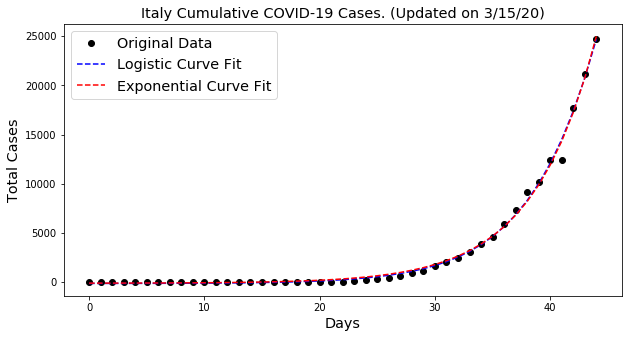



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 13938
	Confirmed cases on 3/8/20 	 6566
	Ratio: 2.12
	Weekly increase: 112.3 %
	Daily increase: 11.4 % per day
	Doubling Time (represents recent growth): 6.4 days

** Based on Logistic Fit**

	R^2: 0.995619391898
	Doubling Time (during middle of growth):  5.98 (± 1.02 ) days


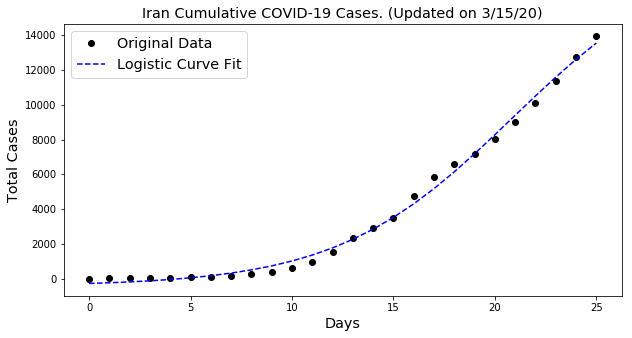



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 8162
	Confirmed cases on 3/8/20 	 7314
	Ratio: 1.12
	Weekly increase: 11.6 %
	Daily increase: 1.6 % per day
	Doubling Time (represents recent growth): 44.2 days

** Based on Logistic Fit**

	R^2: 0.999561063963
	Doubling Time (during middle of growth):  4.03 (± 0.11 ) days


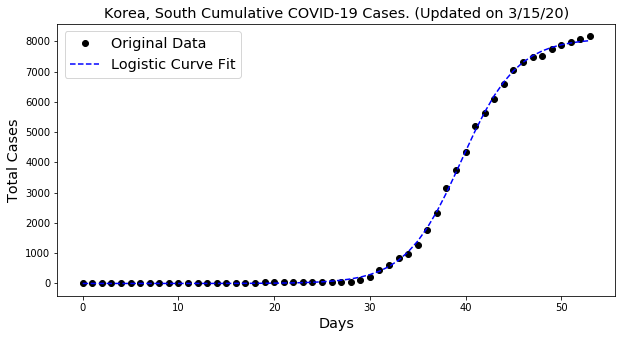



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 7798
	Confirmed cases on 3/8/20 	 673
	Ratio: 11.59
	Weekly increase: 1058.7 %
	Daily increase: 41.9 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.984005736602
	Doubling Time (represents overall growth):  2.16 (± 0.17 ) days


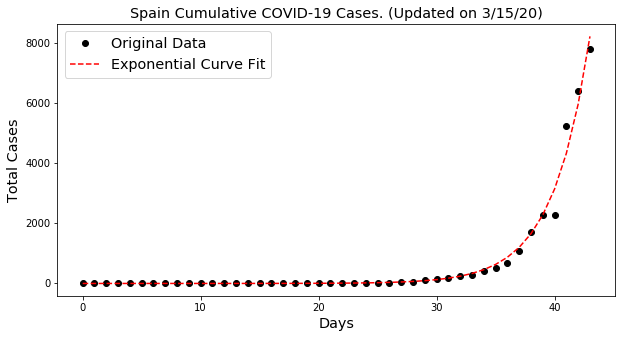



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 5795
	Confirmed cases on 3/8/20 	 1040
	Ratio: 5.57
	Weekly increase: 457.2 %
	Daily increase: 27.8 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.993525011115
	Doubling Time (represents overall growth):  2.55 (± 0.12 ) days


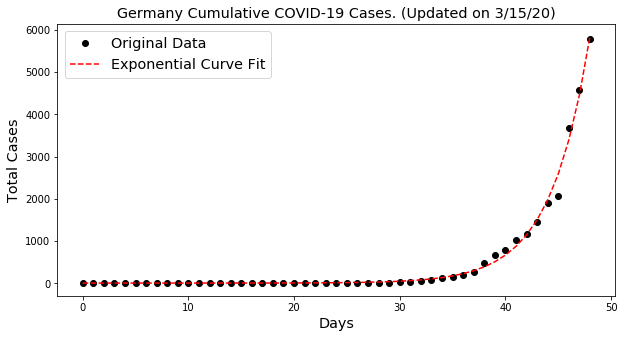



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 4513
	Confirmed cases on 3/8/20 	 1134
	Ratio: 3.98
	Weekly increase: 298.0 %
	Daily increase: 21.8 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.984281631742
	Doubling Time (represents overall growth):  3.22 (± 0.24 ) days


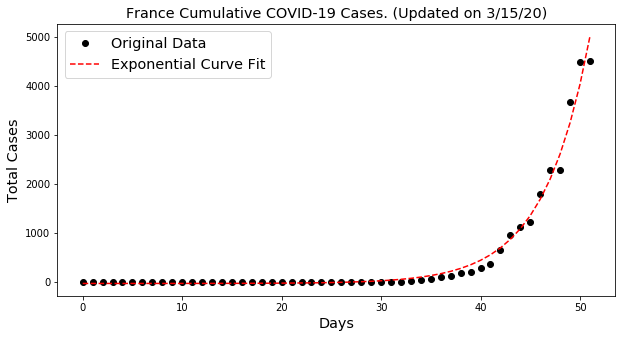



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 3499
	Confirmed cases on 3/8/20 	 518
	Ratio: 6.75
	Weekly increase: 575.5 %
	Daily increase: 31.4 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Exponential Fit **

	R^2: 0.99805222613
	Doubling Time (represents overall growth):  2.58 (± 0.06 ) days


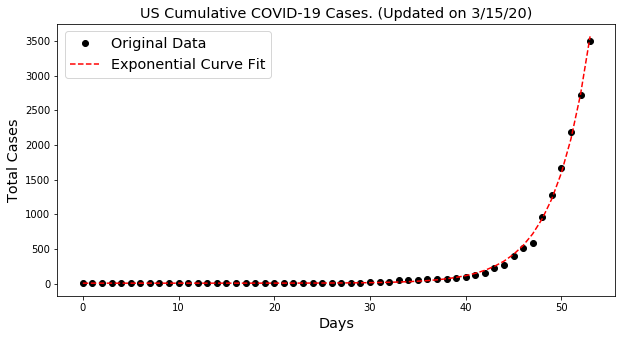



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 2200
	Confirmed cases on 3/8/20 	 337
	Ratio: 6.53
	Weekly increase: 552.8 %
	Daily increase: 30.7 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.984009557323
	Doubling Time (during middle of growth):  4.34 (± 0.43 ) days

** Based on Exponential Fit **

	R^2: 0.984009558193
	Doubling Time (represents overall growth):  2.17 (± 0.3 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


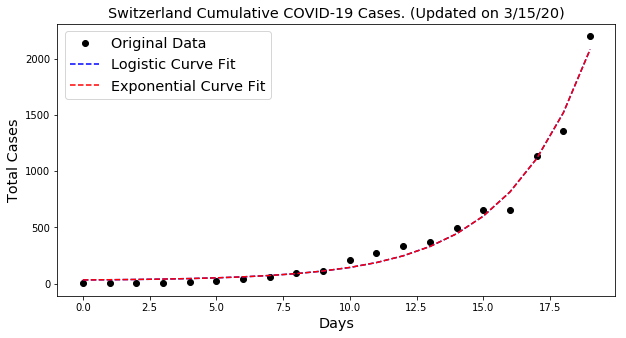



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 1221
	Confirmed cases on 3/8/20 	 176
	Ratio: 6.94
	Weekly increase: 593.8 %
	Daily increase: 31.9 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.994859724997
	Doubling Time (during middle of growth):  2.6 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.977509151524
	Doubling Time (represents overall growth):  3.23 (± 0.63 ) days


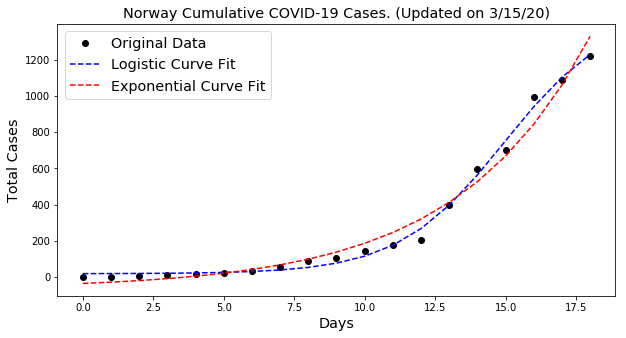



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 1144
	Confirmed cases on 3/8/20 	 274
	Ratio: 4.18
	Weekly increase: 317.5 %
	Daily increase: 22.7 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.980616304655
	Doubling Time (represents overall growth):  2.93 (± 0.26 ) days


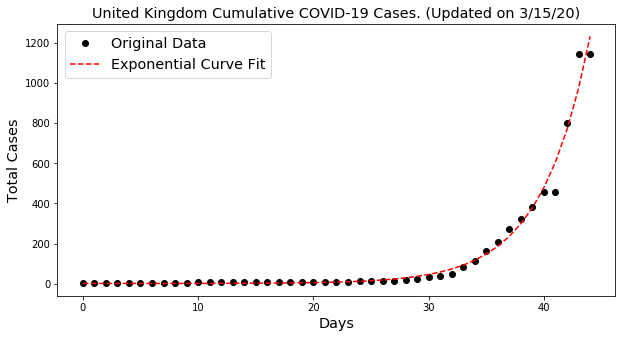



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 1135
	Confirmed cases on 3/8/20 	 265
	Ratio: 4.28
	Weekly increase: 328.3 %
	Daily increase: 23.1 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.991563096301
	Doubling Time (during middle of growth):  5.93 (± 2.79 ) days

** Based on Exponential Fit **

	R^2: 0.991349502169
	Doubling Time (represents overall growth):  3.42 (± 0.45 ) days


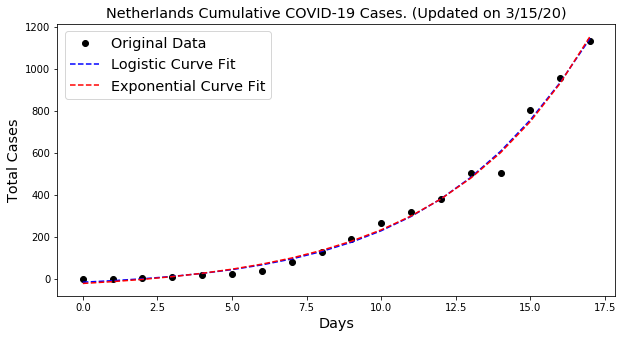



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 1022
	Confirmed cases on 3/8/20 	 203
	Ratio: 5.03
	Weekly increase: 403.4 %
	Daily increase: 26.0 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.985903842292
	Doubling Time (represents overall growth):  3.05 (± 0.23 ) days


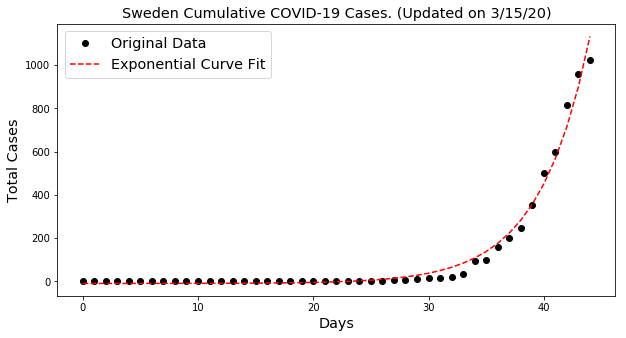



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 886
	Confirmed cases on 3/8/20 	 200
	Ratio: 4.43
	Weekly increase: 343.0 %
	Daily increase: 23.7 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.98604951828
	Doubling Time (represents overall growth):  2.8 (± 0.22 ) days


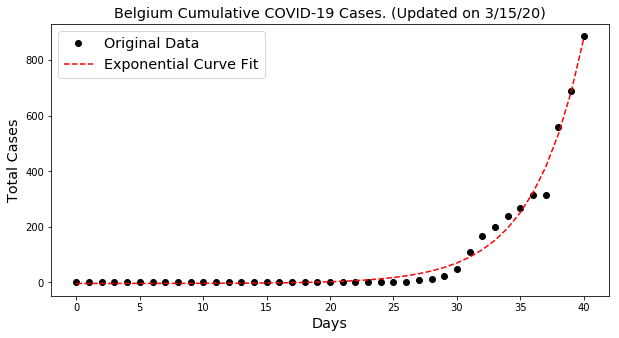



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 875
	Confirmed cases on 3/8/20 	 37
	Ratio: 23.65
	Weekly increase: 2264.9 %
	Daily increase: 57.1 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Logistic Fit**

	R^2: 0.998540508322
	Doubling Time (during middle of growth):  1.43 (± 0.14 ) days


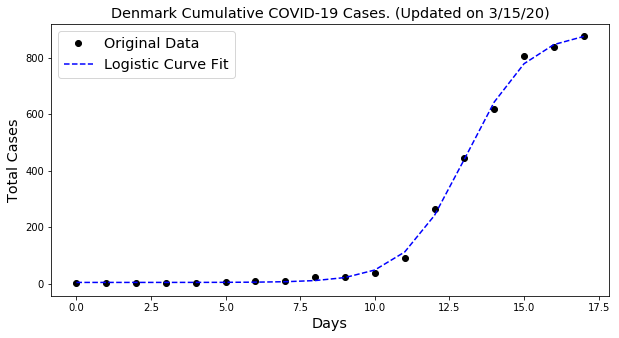



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 860
	Confirmed cases on 3/8/20 	 104
	Ratio: 8.27
	Weekly increase: 726.9 %
	Daily increase: 35.2 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.997036943355
	Doubling Time (during middle of growth):  4.02 (± 0.76 ) days

** Based on Exponential Fit **

	R^2: 0.996845882445
	Doubling Time (represents overall growth):  2.23 (± 0.13 ) days


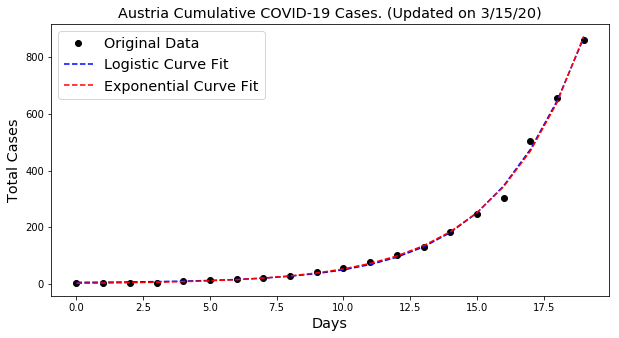



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 839
	Confirmed cases on 3/8/20 	 502
	Ratio: 1.67
	Weekly increase: 67.1 %
	Daily increase: 7.6 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.997475514931
	Doubling Time (during middle of growth):  13.26 (± 1.33 ) days

** Based on Exponential Fit **

	R^2: 0.996429563047
	Doubling Time (represents overall growth):  8.52 (± 0.35 ) days


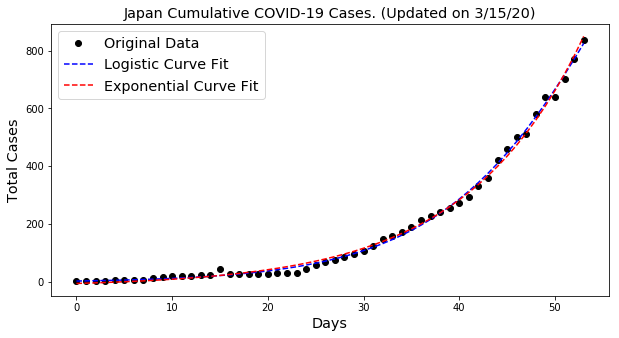



Cruise Ship

** Based on Logistic Fit**

	R^2: 0.995600494592
	Doubling Time (during middle of growth):  2.69 (± 0.29 ) days


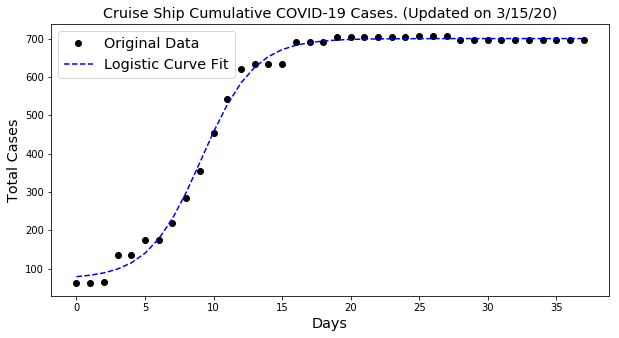



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 428
	Confirmed cases on 3/8/20 	 99
	Ratio: 4.32
	Weekly increase: 332.3 %
	Daily increase: 23.3 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.954117993736
	Doubling Time (represents overall growth):  2.86 (± 0.37 ) days


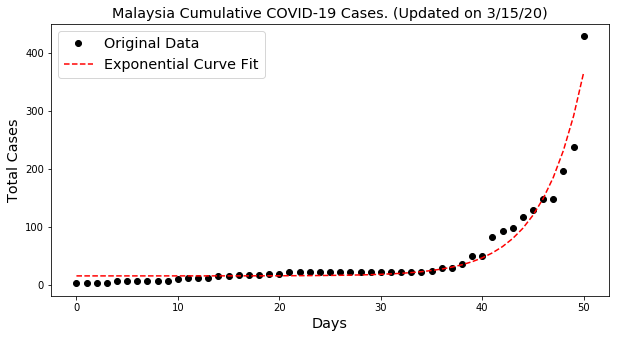



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 401
	Confirmed cases on 3/8/20 	 15
	Ratio: 26.73
	Weekly increase: 2573.3 %
	Daily increase: 59.9 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Logistic Fit**

	R^2: 0.970934766949
	Doubling Time (during middle of growth):  0.38 (± 0.28 ) days


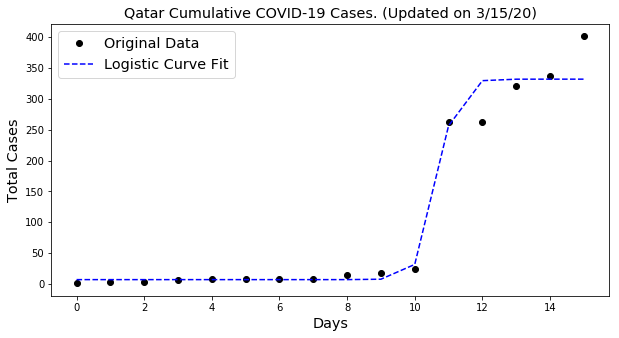



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 331
	Confirmed cases on 3/8/20 	 73
	Ratio: 4.53
	Weekly increase: 353.4 %
	Daily increase: 24.1 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.975949149443
	Doubling Time (during middle of growth):  4.9 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.975949150958
	Doubling Time (represents overall growth):  2.45 (± 0.44 ) days


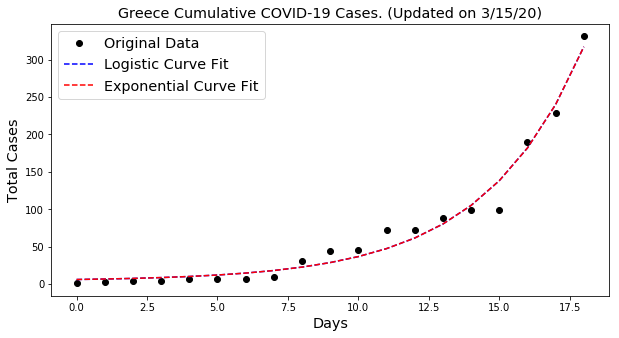



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 297
	Confirmed cases on 3/8/20 	 76
	Ratio: 3.91
	Weekly increase: 290.8 %
	Daily increase: 21.5 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Exponential Fit **

	R^2: 0.989233654639
	Doubling Time (represents overall growth):  3.2 (± 0.2 ) days


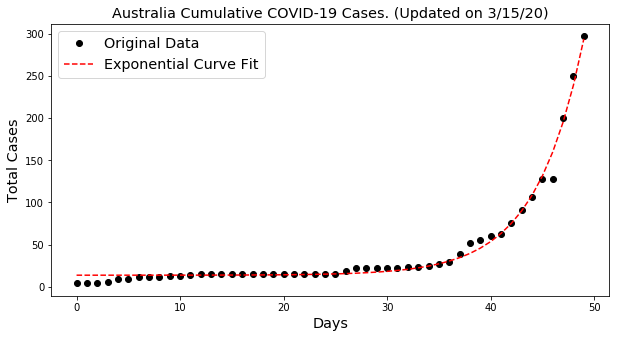



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 253
	Confirmed cases on 3/8/20 	 31
	Ratio: 8.16
	Weekly increase: 716.1 %
	Daily increase: 35.0 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.992845062271
	Doubling Time (during middle of growth):  3.83 (± 1.53 ) days

** Based on Exponential Fit **

	R^2: 0.992482268695
	Doubling Time (represents overall growth):  2.26 (± 0.28 ) days


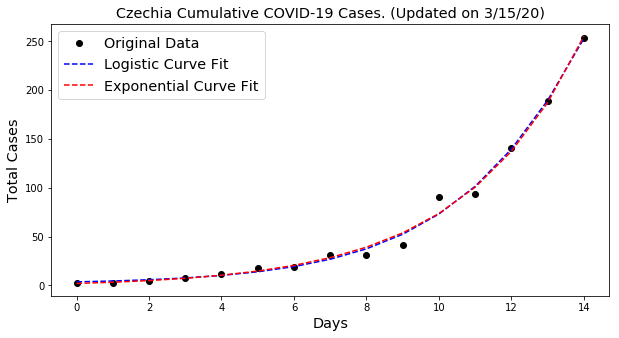



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 252
	Confirmed cases on 3/8/20 	 64
	Ratio: 3.94
	Weekly increase: 293.8 %
	Daily increase: 21.6 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.989250356087
	Doubling Time (represents overall growth):  3.34 (± 0.21 ) days


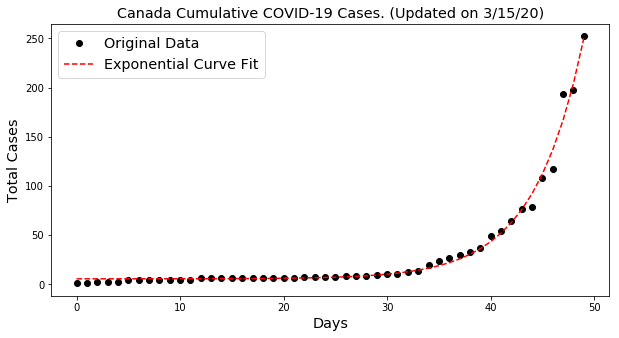



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 251
	Confirmed cases on 3/8/20 	 61
	Ratio: 4.11
	Weekly increase: 311.5 %
	Daily increase: 22.4 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.99737019261
	Doubling Time (during middle of growth):  6.11 (± 1.1 ) days

** Based on Exponential Fit **

	R^2: 0.997311139833
	Doubling Time (represents overall growth):  3.24 (± 0.17 ) days


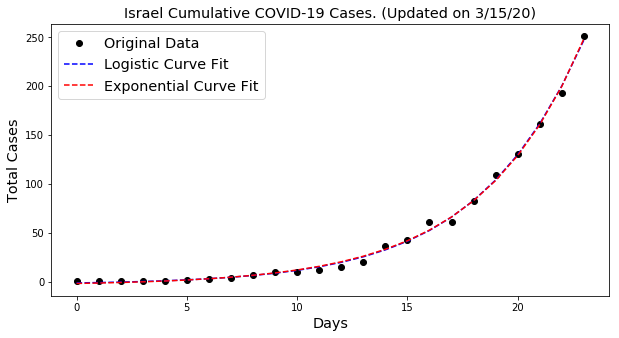



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 245
	Confirmed cases on 3/8/20 	 30
	Ratio: 8.17
	Weekly increase: 716.7 %
	Daily increase: 35.0 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.991239568019
	Doubling Time (during middle of growth):  3.43 (± 0.85 ) days

** Based on Exponential Fit **

	R^2: 0.991239568466
	Doubling Time (represents overall growth):  1.71 (± 0.22 ) days


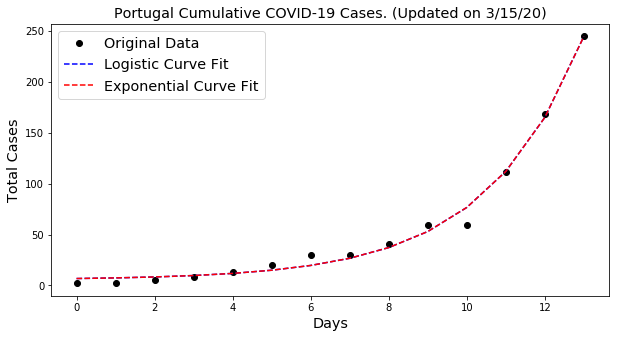



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 244
	Confirmed cases on 3/8/20 	 23
	Ratio: 10.61
	Weekly increase: 960.9 %
	Daily increase: 40.1 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Exponential Fit **

	R^2: 0.970439200813
	Doubling Time (represents overall growth):  1.97 (± 0.21 ) days


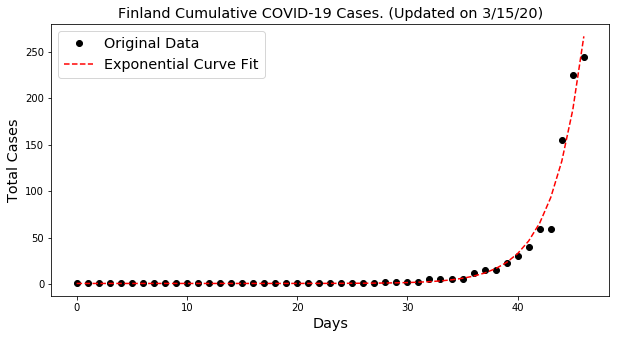



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 226
	Confirmed cases on 3/8/20 	 150
	Ratio: 1.51
	Weekly increase: 50.7 %
	Daily increase: 6.0 % per day
	Doubling Time (represents recent growth): 11.8 days

** Based on Logistic Fit**

	R^2: 0.97118018281
	Doubling Time (during middle of growth):  44.93 (± 13.78 ) days

** Based on Exponential Fit **

	R^2: 0.971180183429
	Doubling Time (represents overall growth):  22.47 (± 5.41 ) days


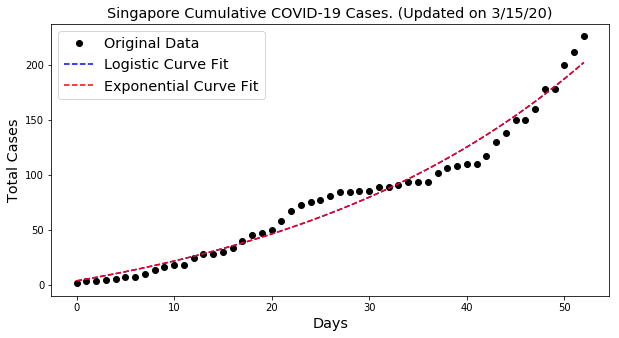



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 219
	Confirmed cases on 3/8/20 	 16
	Ratio: 13.69
	Weekly increase: 1268.8 %
	Daily increase: 45.3 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Logistic Fit**

	R^2: 0.998909538075
	Doubling Time (during middle of growth):  1.92 (± 0.25 ) days

** Based on Exponential Fit **

	R^2: 0.984552420001
	Doubling Time (represents overall growth):  2.54 (± 0.7 ) days


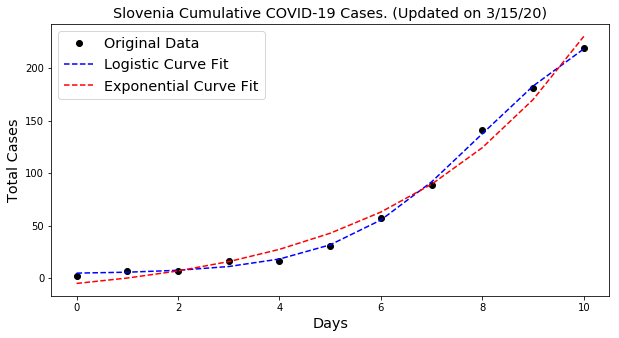



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 214
	Confirmed cases on 3/8/20 	 85
	Ratio: 2.52
	Weekly increase: 151.8 %
	Daily increase: 14.1 % per day
	Doubling Time (represents recent growth): 5.3 days

** Based on Logistic Fit**

	R^2: 0.954858154233
	Doubling Time (during middle of growth):  3.04 (± 1.52 ) days


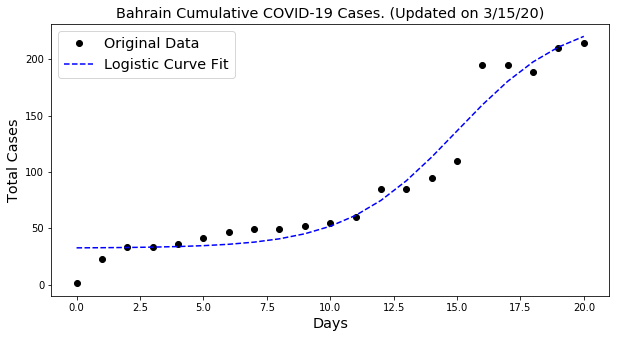



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 171
	Confirmed cases on 3/8/20 	 50
	Ratio: 3.42
	Weekly increase: 242.0 %
	Daily increase: 19.2 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.989299318477
	Doubling Time (during middle of growth):  9.85 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.989299318856
	Doubling Time (represents overall growth):  4.93 (± 0.99 ) days


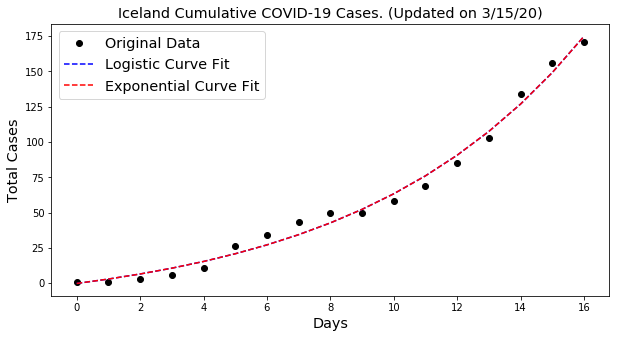



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 171
	Confirmed cases on 3/8/20 	 10
	Ratio: 17.1
	Weekly increase: 1610.0 %
	Daily increase: 50.0 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Exponential Fit **

	R^2: 0.973163940514
	Doubling Time (represents overall growth):  1.33 (± 0.24 ) days


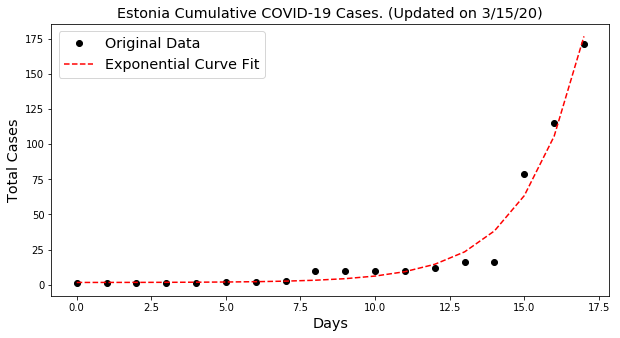



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 162
	Confirmed cases on 3/8/20 	 20
	Ratio: 8.1
	Weekly increase: 710.0 %
	Daily increase: 34.8 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.961794485785
	Doubling Time (during middle of growth):  0.53 (± 0.33 ) days


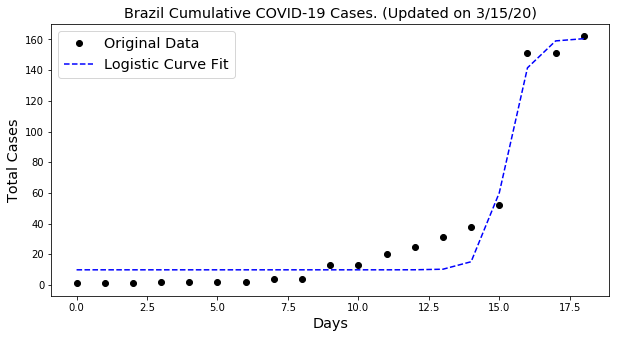



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 140
	Confirmed cases on 3/8/20 	 10
	Ratio: 14.0
	Weekly increase: 1300.0 %
	Daily increase: 45.8 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Exponential Fit **

	R^2: 0.987998023406
	Doubling Time (represents overall growth):  2.04 (± 0.14 ) days


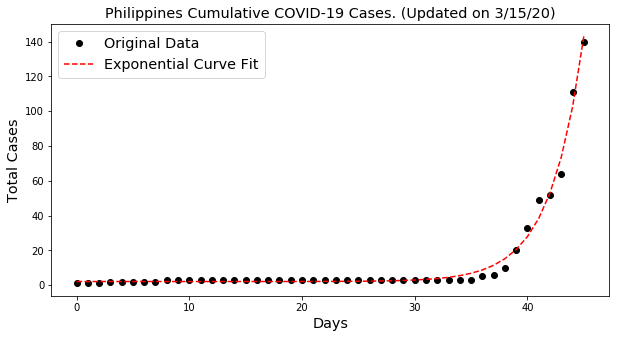



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 131
	Confirmed cases on 3/8/20 	 15
	Ratio: 8.73
	Weekly increase: 773.3 %
	Daily increase: 36.3 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.988797147264
	Doubling Time (during middle of growth):  2.17 (± 0.6 ) days

** Based on Exponential Fit **

	R^2: 0.974808269664
	Doubling Time (represents overall growth):  2.3 (± 0.42 ) days


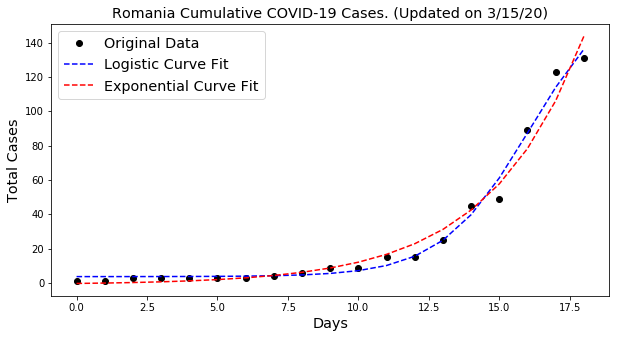



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 129
	Confirmed cases on 3/8/20 	 19
	Ratio: 6.79
	Weekly increase: 578.9 %
	Daily increase: 31.5 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.964322788918
	Doubling Time (during middle of growth):  2.68 (± 1.66 ) days

** Based on Exponential Fit **

	R^2: 0.958787249633
	Doubling Time (represents overall growth):  2.53 (± 0.73 ) days


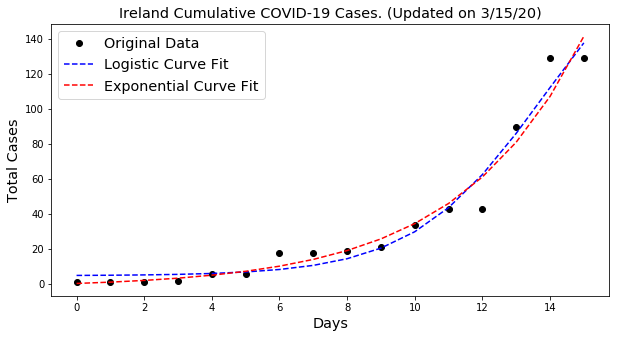



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 119
	Confirmed cases on 3/8/20 	 11
	Ratio: 10.82
	Weekly increase: 981.8 %
	Daily increase: 40.5 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.995364375245
	Doubling Time (during middle of growth):  2.52 (± 0.74 ) days

** Based on Exponential Fit **

	R^2: 0.989645744222
	Doubling Time (represents overall growth):  2.43 (± 0.48 ) days


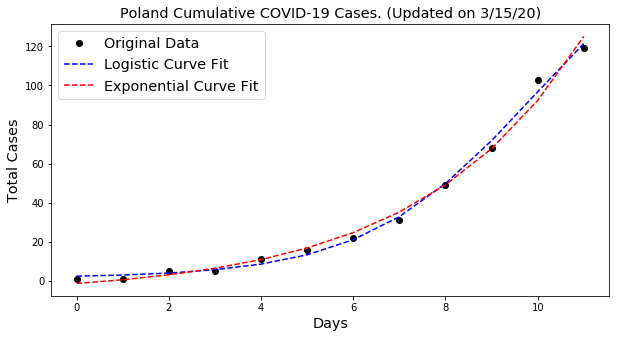



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 117
	Confirmed cases on 3/8/20 	 6
	Ratio: 19.5
	Weekly increase: 1850.0 %
	Daily increase: 52.9 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.985329212
	Doubling Time (during middle of growth):  2.99 (± 1.51 ) days

** Based on Exponential Fit **

	R^2: 0.982652612593
	Doubling Time (represents overall growth):  2.21 (± 0.45 ) days


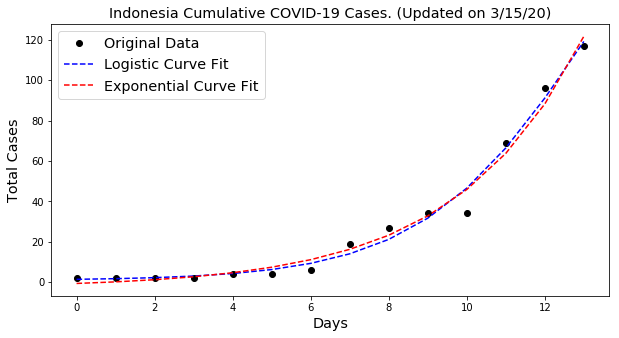



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 116
	Confirmed cases on 3/8/20 	 60
	Ratio: 1.93
	Weekly increase: 93.3 %
	Daily increase: 9.9 % per day
	Doubling Time (represents recent growth): 7.4 days

** Based on Logistic Fit**

	R^2: 0.982145080651
	Doubling Time (during middle of growth):  19.03 (± 13.03 ) days

** Based on Exponential Fit **

	R^2: 0.9821450814
	Doubling Time (represents overall growth):  9.51 (± 3.18 ) days


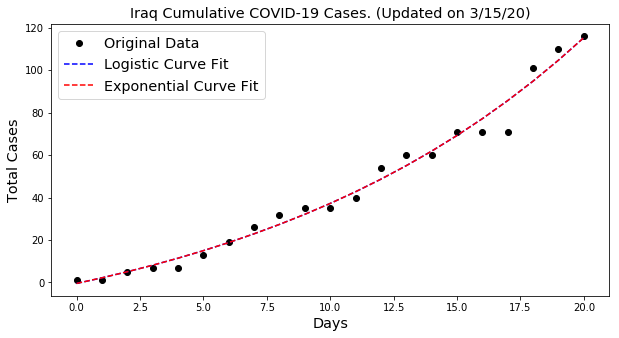



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 114
	Confirmed cases on 3/8/20 	 50
	Ratio: 2.28
	Weekly increase: 128.0 %
	Daily increase: 12.5 % per day
	Doubling Time (represents recent growth): 5.9 days


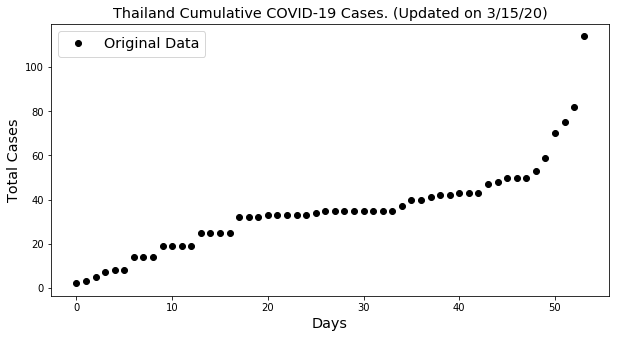



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 113
	Confirmed cases on 3/8/20 	 39
	Ratio: 2.9
	Weekly increase: 189.7 %
	Daily increase: 16.4 % per day
	Doubling Time (represents recent growth): 4.6 days

** Based on Exponential Fit **

	R^2: 0.980863146667
	Doubling Time (represents overall growth):  4.09 (± 0.36 ) days


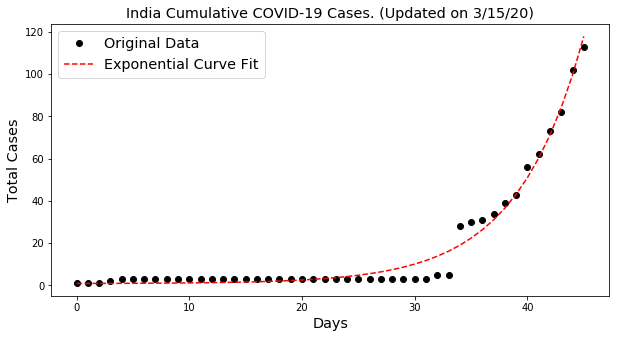



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 112
	Confirmed cases on 3/8/20 	 64
	Ratio: 1.75
	Weekly increase: 75.0 %
	Daily increase: 8.3 % per day
	Doubling Time (represents recent growth): 8.7 days


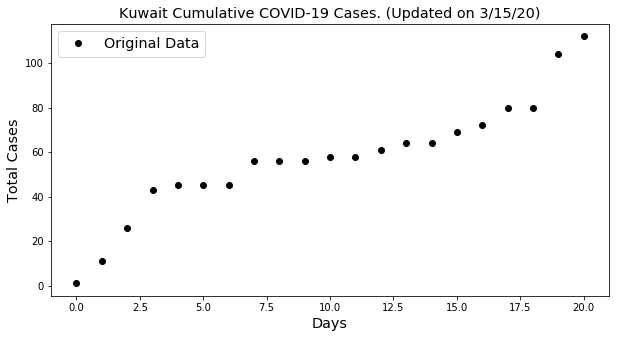



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 110
	Confirmed cases on 3/8/20 	 32
	Ratio: 3.44
	Weekly increase: 243.8 %
	Daily increase: 19.3 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.993193262767
	Doubling Time (during middle of growth):  7.45 (± 2.53 ) days

** Based on Exponential Fit **

	R^2: 0.993179194933
	Doubling Time (represents overall growth):  3.86 (± 0.35 ) days


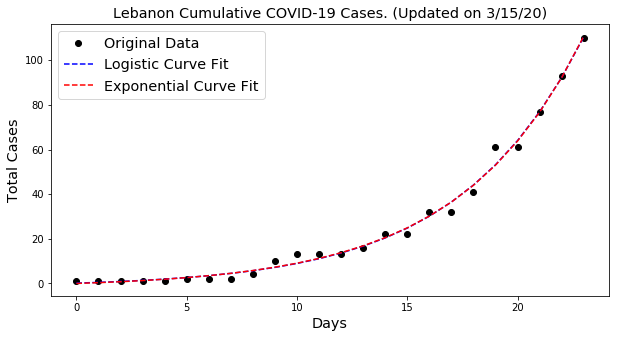



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 110
	Confirmed cases on 3/8/20 	 49
	Ratio: 2.24
	Weekly increase: 124.5 %
	Daily increase: 12.2 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.968781650502
	Doubling Time (during middle of growth):  3.66 (± 1.24 ) days

** Based on Exponential Fit **

	R^2: 0.951345951178
	Doubling Time (represents overall growth):  3.83 (± 0.74 ) days


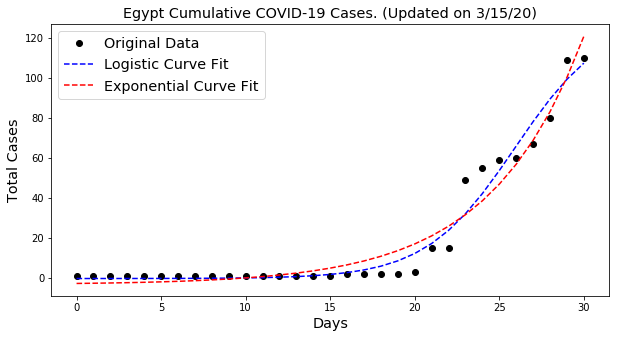



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 103
	Confirmed cases on 3/8/20 	 11
	Ratio: 9.36
	Weekly increase: 836.4 %
	Daily increase: 37.7 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.984295539772
	Doubling Time (during middle of growth):  1.05 (± 0.39 ) days


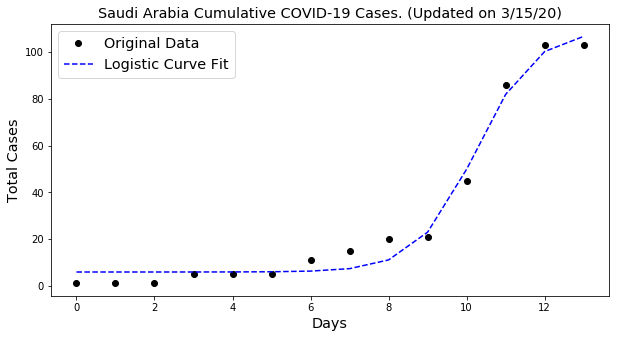



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 101
	Confirmed cases on 3/8/20 	 36
	Ratio: 2.81
	Weekly increase: 180.6 %
	Daily increase: 15.9 % per day
	Doubling Time (represents recent growth): 4.7 days

** Based on Logistic Fit**

	R^2: 0.989190223855
	Doubling Time (during middle of growth):  6.29 (± 3.24 ) days

** Based on Exponential Fit **

	R^2: 0.987268800805
	Doubling Time (represents overall growth):  6.13 (± 1.48 ) days


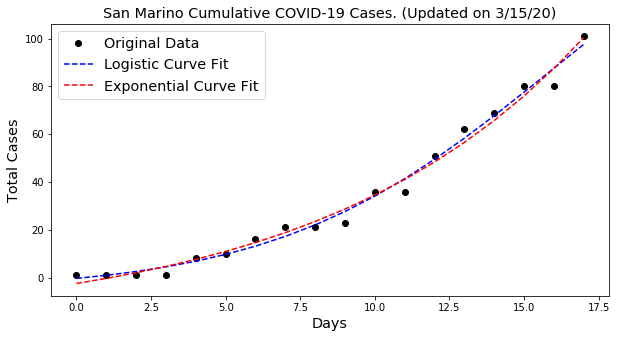

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


         Countries  Inferred Doubling Time  Recent Doubling Time
0            China                     6.5                2181.1
1            Italy                     3.8                   4.0
2             Iran                     6.0                   6.4
3     Korea, South                     4.0                  44.2
4            Spain                     2.2                   2.0
5          Germany                     2.5                   2.8
6           France                     3.2                   3.5
7               US                     2.6                   2.5
8      Switzerland                     2.2                   2.6
9           Norway                     2.6                   2.5
10  United Kingdom                     2.9                   3.4
11     Nethe

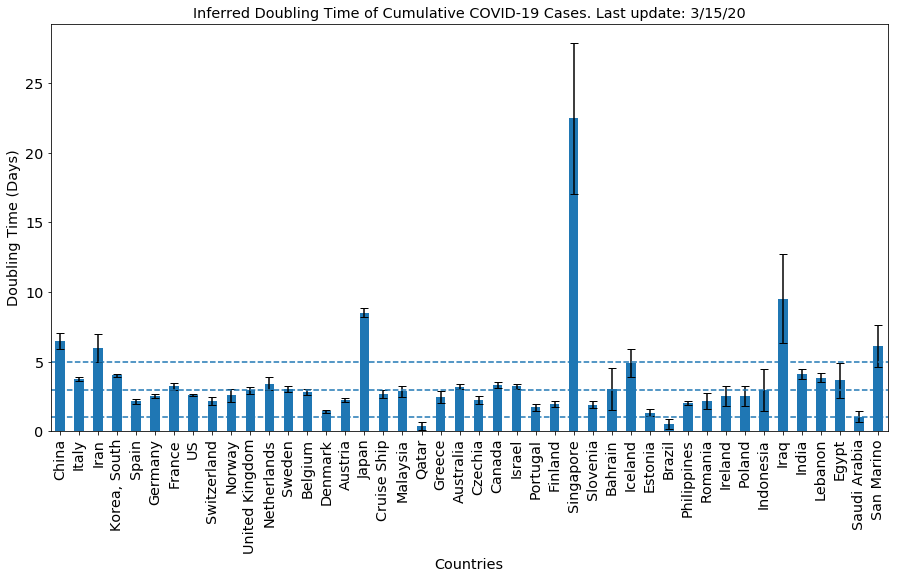

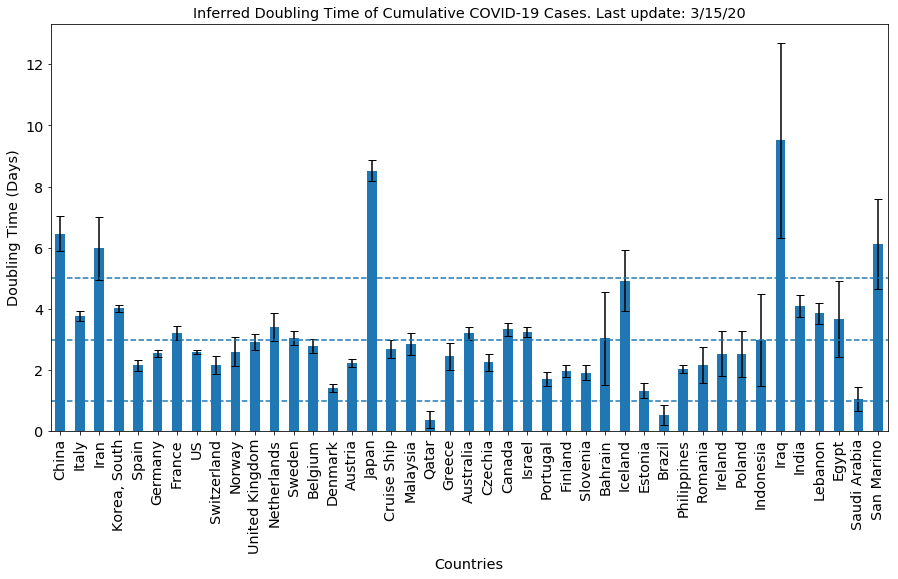

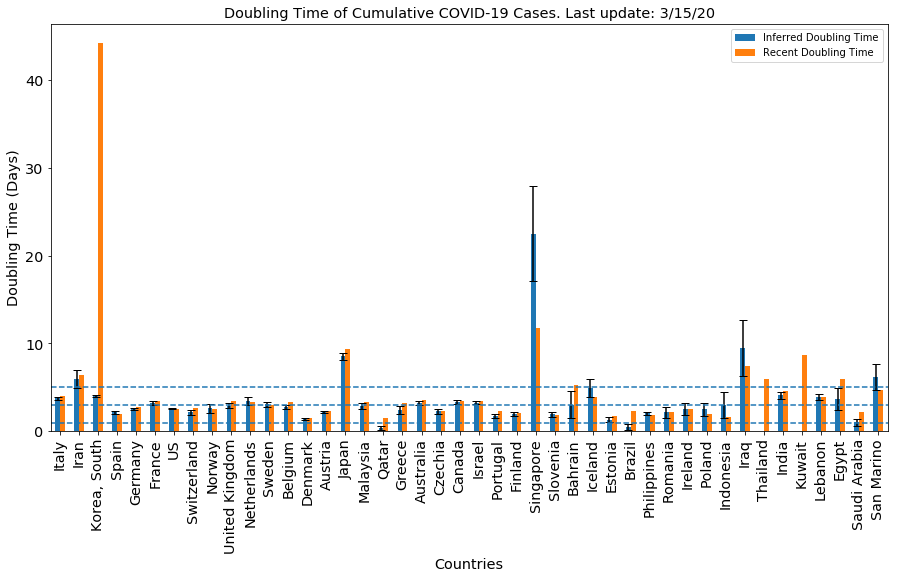

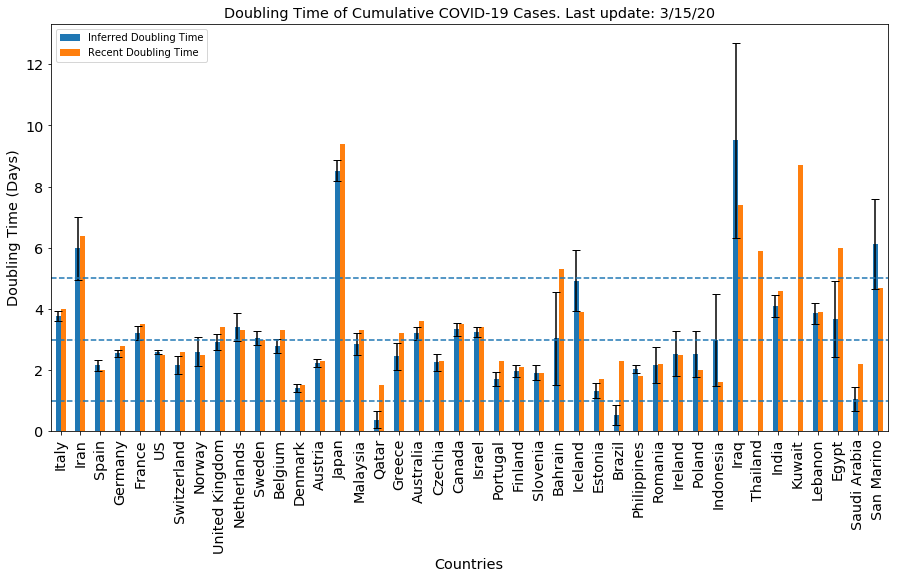

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary

Error parsing US state: Virgin Islands, U.S.

Number of confirmed US COVID-19 cases by state as of 3/15/20


,3/15/20
Province/State,
New York,732
Washington,643
California,426
Massachusetts,164
Colorado,131
Florida,115
Georgia,99
New Jersey,98
Illinois,93


## Curve Fitting US COVID-19 Cases

                3/15/20
Province/State         
New York            732
Washington          643
California          426
Massachusetts       164
Colorado            131
Florida             115


US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 732
	Confirmed cases on 3/8/20 	 106
	Ratio: 6.91
	Weekly increase: 590.6 %
	Daily increase: 31.8 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.99719698214
	Doubling Time (during middle of growth):  5.33 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.997196982421
	Doubling Time (represents overall growth):  2.67 (± 0.24 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


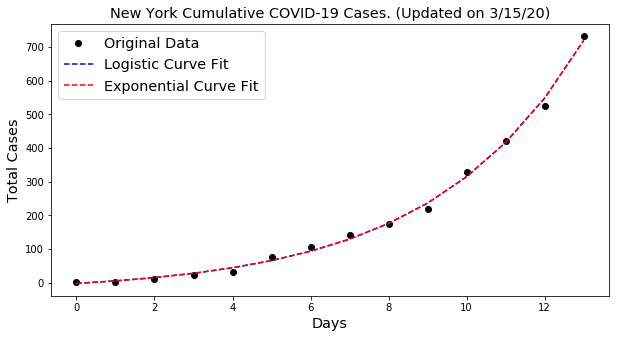



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 643
	Confirmed cases on 3/8/20 	 122
	Ratio: 5.27
	Weekly increase: 427.0 %
	Daily increase: 26.8 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.971677046475
	Doubling Time (represents overall growth):  3.25 (± 0.31 ) days


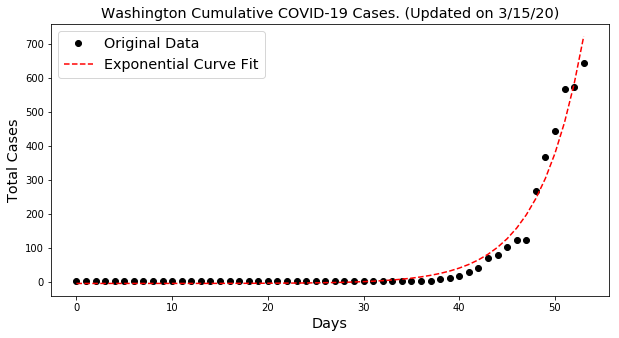



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 426
	Confirmed cases on 3/8/20 	 95
	Ratio: 4.48
	Weekly increase: 348.4 %
	Daily increase: 23.9 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Exponential Fit **

	R^2: 0.998178677067
	Doubling Time (represents overall growth):  3.04 (± 0.08 ) days


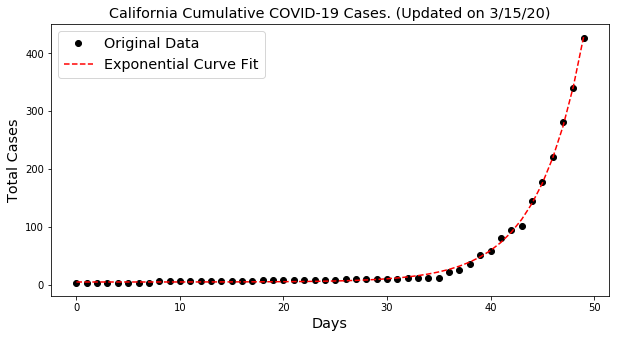



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 164
	Confirmed cases on 3/8/20 	 22
	Ratio: 7.45
	Weekly increase: 645.5 %
	Daily increase: 33.2 % per day
	Doubling Time (represents recent growth): 2.4 days


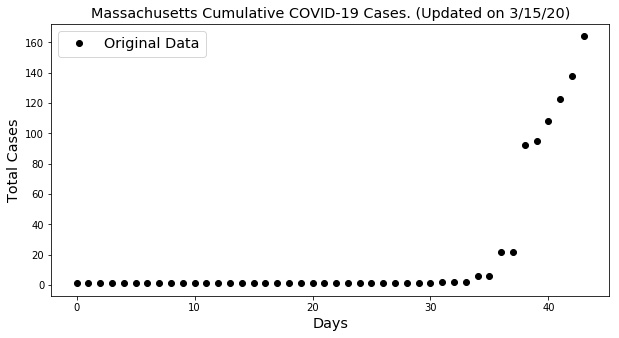



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 131
	Confirmed cases on 3/8/20 	 7
	Ratio: 18.71
	Weekly increase: 1771.4 %
	Daily increase: 52.0 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Logistic Fit**

	R^2: 0.979930278324
	Doubling Time (during middle of growth):  2.85 (± 2.91 ) days

** Based on Exponential Fit **

	R^2: 0.979263405921
	Doubling Time (represents overall growth):  1.83 (± 0.55 ) days


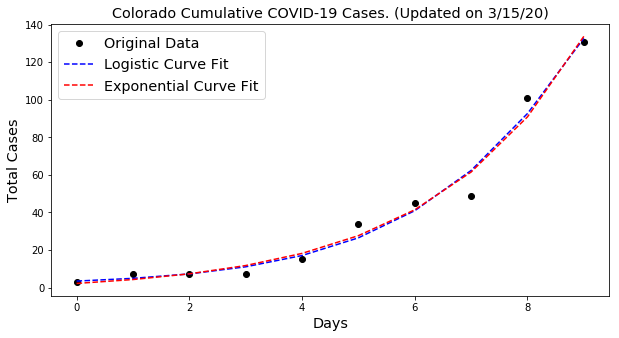



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/15/20 	 115
	Confirmed cases on 3/8/20 	 10
	Ratio: 11.5
	Weekly increase: 1050.0 %
	Daily increase: 41.8 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.997742018573
	Doubling Time (during middle of growth):  3.49 (± 0.19 ) days

** Based on Exponential Fit **

	R^2: 0.997742018821
	Doubling Time (represents overall growth):  1.75 (± 0.12 ) days


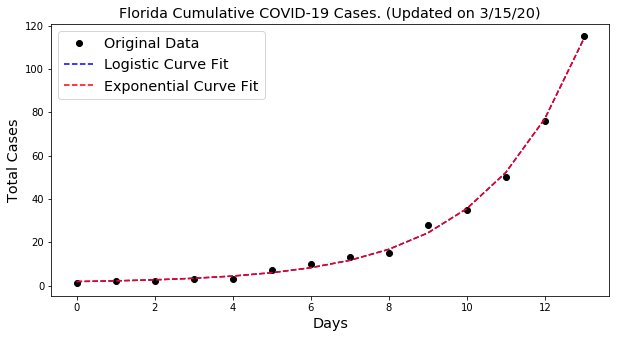

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


          States  Inferred Doubling Time  Recent Doubling Time
0       New York                     2.7                   2.5
1     Washington                     3.2                   2.9
2     California                     3.0                   3.2
3  Massachusetts                     NaN                   2.4
4       Colorado                     1.8                   1.7
5        Florida                     1.7                   2.0




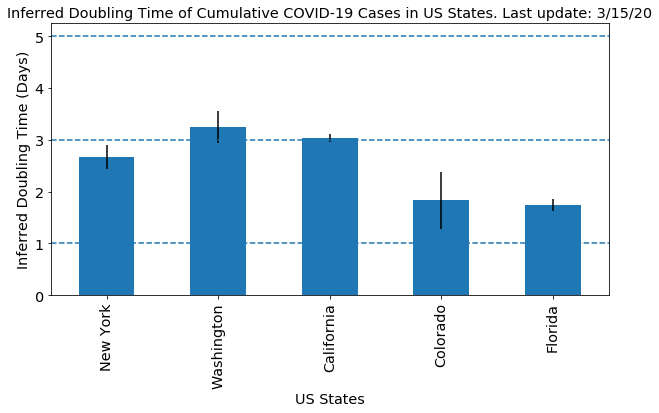

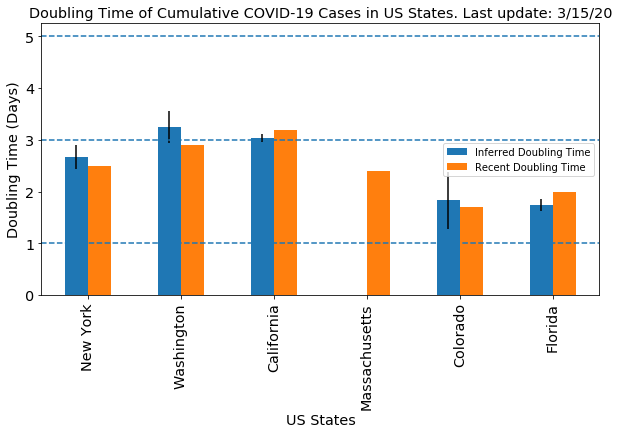

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()